In [1]:
import matplotlib.pyplot as plt
import geopandas
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cartopy.crs as ccrs
import numpy as np

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

In [4]:
municipios = geopandas.read_file('deps/municipios/Municipios_IBGE.shp')

In [5]:
municipios['idh'] = float('nan')

In [6]:
municipios.head()

,MSLINK,MAPID,AREA_1,PERIMETRO_,NOME,SEDE,LATITUDESE,LONGITUDES,AREA_TOT_G,Cod_ibge,Label_N,geometry,idh
0,4985,99,118.280,61.626,HERVEIRAS,1,-29.407,-52.653,118.280,4309571,Herveiras,"POLYGON ((-52.77319 -29.44486, -52.77602 -29.4...",NaN
1,4986,99,228.849,81.715,HORIZONTINA,1,-27.626,-54.308,228.849,4309605,Horizontina,"POLYGON ((-54.39910 -27.57012, -54.38675 -27.5...",NaN
2,4987,99,822.943,184.883,HULHA NEGRA,1,-31.404,-53.869,822.943,4309654,Hulha Negra,"POLYGON ((-53.98933 -31.55208, -53.99221 -31.5...",NaN
3,4988,99,135.246,70.392,HUMAITA,1,-27.563,-53.974,135.246,4309704,Humaitá,"POLYGON ((-54.07227 -27.57674, -54.06089 -27.5...",NaN
4,4989,99,193.109,70.655,IBARAMA,1,-29.419,-53.135,193.109,4309753,Ibarama,"POLYGON ((-53.26582 -29.44975, -53.26701 -29.4...",NaN


In [7]:
idh = pd.read_csv('deps/idh_rs.csv', encoding='latin1', delimiter=';')

In [8]:
idh.head()

,municipio,idh
0,Aceguá,0.687
1,Água Santa,0.75
2,Agudo,0.694
3,Ajuricaba,0.753
4,Alecrim,0.672


In [9]:
for idx, row in municipios.iterrows():
    municipio = row['Label_N']
    #print(municipio)
    for idx1, row1 in idh.iterrows():
        municipio_idh = row1['municipio']
        
        if municipio.lower() == municipio_idh.lower():
            if row1['idh'] == '-':
                municipios.loc[idx, 'idh'] = float('nan')
            else:
                municipios.loc[idx, 'idh'] = row1['idh']

In [10]:
lista_municipio = ['Caxias do Sul', 'Santa Maria', 'Porto Alegre', 'Pelotas']
def plot_municipios(municipios, lista_municipio, ax, c='black', delta=0.05):
    x = []
    y = []
    for index, row in municipios.iterrows():
        for m in lista_municipio:
            if row['NOME'] == m.upper():
                y.append(row['LATITUDESE'])
                x.append(row['LONGITUDES'])
    ax.scatter(x=x, y=y, marker='x', c=c)
    for i, txt in enumerate(lista_municipio[::-1]):
        ax.annotate(txt, (x[i]+delta, y[i]+delta), c=c)

In [11]:
ocorr = geopandas.read_file('cprm/OcorrÛncias_minerais.shp')
ocorr = ocorr[ocorr['UF'] == 'RS']

DriverError: cprm/OcorrÛncias_minerais.shp: No such file or directory

In [12]:
ocorr.head()

,ID_AFLORAM,ORIGEM,METODO_GEO,TOPONIMIA,MUNICIPIO,UF,GEOLOGO,DATA_CADAS,TIPO_AFLOR,DESCRICAO,...,SITUACAO_G,MOTIVO_I_1,SUBSTANCIA,ROCHAS_HOS,ROCHAS_ENC,CLASSES_UT,MORFOLOGIA,TEXTURAS,TIPOS_ALTE,geometry
0,394240,Oracle,GPS Manual pós 24/05/2000,Perfil Quaraí- Baltazar Brum,Quaraí,RS,Magda Bergmann,2017-03-03,Lajedo ou Lajeiro,"Geodos rolados centimétricos, alguns de 10cm d...",...,None,None,Ágata,None,None,None,None,None,None,POINT (-56.31245 -30.25307)
1,192489,Oracle,Levantamento em mapa 1:1.000.000,Arroio Nicolau,Quaraí,RS,A Definir,2003-09-19,None,None,...,None,None,"Calcedônia, Quartzo hialino (Cristal de rocha)...",None,None,"Gemas, Rochas e minerais industriais",None,None,None,POINT (-55.97160 -30.16046)
2,182430,Oracle,Levantamento em mapa 1:1.000.000,Arroio Pai Passo,Quaraí,RS,A Definir,2003-09-23,None,None,...,None,None,"Calcedônia gemológica, Quartzo hialino (Crista...",None,None,"Gemas, Rochas e minerais industriais",None,None,None,POINT (-55.96715 -30.33574)
3,394099,Oracle,GPS Manual pós 24/05/2000,Perfil Sarandi - Fazenda Alegria,Sant' Ana do Livramento,RS,Magda Bergmann,2016-12-19,Lajedo ou Lajeiro,Basalto com disjunção colunar brechada. Rocha ...,...,None,None,Ágata,None,None,None,None,None,None,POINT (-55.93142 -30.55259)
4,197761,Oracle,Levantamento em mapa 1:1.000.000,Passo do Pai Passo,Quaraí,RS,A Definir,2003-09-16,None,None,...,None,None,"Calcedônia gemológica, Quartzo hialino (Crista...",None,None,"Gemas, Rochas e minerais industriais",None,None,None,POINT (-55.92687 -30.31880)


In [13]:
producao = pd.read_excel("deps/Arrecadacao_2020.xlsx", index_col=0)
producao = producao.fillna(0)

In [14]:
producao['TOTAL'] = producao.sum(axis=1)

In [15]:
producao.head()

,ÁGATA,ÁGUA MINERAL,AMETISTA,AREIA,AREIA FLUVIAL,AREIA QUARTZOSA,ARENITO,ARGILA,BASALTO,BASALTO P/ BRITA,...,CAULIM,DIABÁSIO,GIPSITA,GNAISSE,GRANITO,RIÓLITO,SAIBRO,SIENITO,TALCO,TOTAL
Arrecadação de CFEM 2020 (completo),,,,,,,,,,,,,,,,,,,,,
Água Santa,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,36388.62,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36388.62
Agudo,0.0,0.0,0.0,0.00,0.0,0.0,0.0,324.72,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,324.72
Alecrim,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,2314.63,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2314.63
Alegrete,0.0,0.0,0.0,962.49,0.0,0.0,0.0,0.00,16060.27,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,17023.36
Alegria,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,3282.14,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3282.14


In [16]:
municipios['arrecadacao'] = 0
for index, row in producao.iterrows():
    for index1, row1 in municipios.iterrows():
        if index.upper() == row1['NOME']:
            municipios.loc[index1, 'arrecadacao'] = row['TOTAL']

In [17]:
for idx, i in enumerate(np.array(municipios['idh'], dtype=float)):
    if np.isnan(i):
        print(idx)

495


In [18]:
municipios.head()

,MSLINK,MAPID,AREA_1,PERIMETRO_,NOME,SEDE,LATITUDESE,LONGITUDES,AREA_TOT_G,Cod_ibge,Label_N,geometry,idh,arrecadacao
0,4985,99,118.280,61.626,HERVEIRAS,1,-29.407,-52.653,118.280,4309571,Herveiras,"POLYGON ((-52.77319 -29.44486, -52.77602 -29.4...",0.616,0.00
1,4986,99,228.849,81.715,HORIZONTINA,1,-27.626,-54.308,228.849,4309605,Horizontina,"POLYGON ((-54.39910 -27.57012, -54.38675 -27.5...",0.783,0.00
2,4987,99,822.943,184.883,HULHA NEGRA,1,-31.404,-53.869,822.943,4309654,Hulha Negra,"POLYGON ((-53.98933 -31.55208, -53.99221 -31.5...",0.643,245.01
3,4988,99,135.246,70.392,HUMAITA,1,-27.563,-53.974,135.246,4309704,Humaitá,"POLYGON ((-54.07227 -27.57674, -54.06089 -27.5...",0.738,0.00
4,4989,99,193.109,70.655,IBARAMA,1,-29.419,-53.135,193.109,4309753,Ibarama,"POLYGON ((-53.26582 -29.44975, -53.26701 -29.4...",0.652,0.00


In [19]:
#municipios.loc[495]

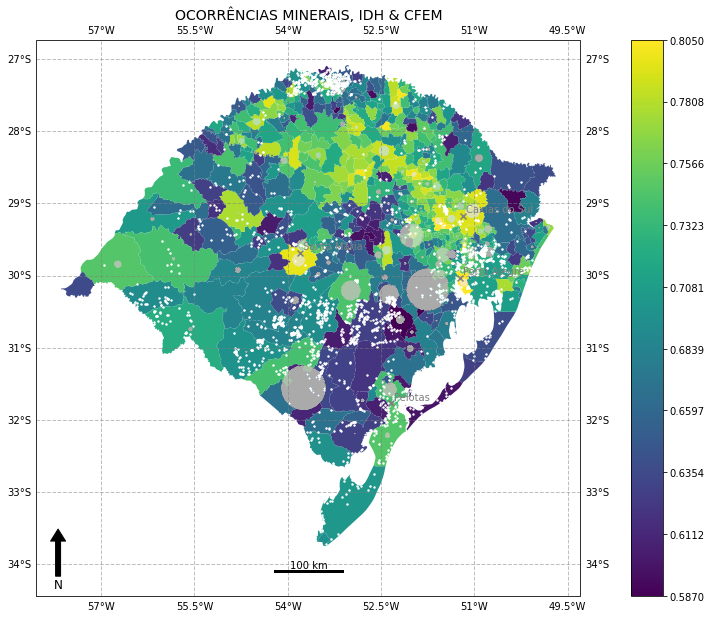

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': ccrs.PlateCarree()})
municipios.plot(ax=ax, column='idh', legend=False, cmap='viridis')

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
mappable = plt.cm.ScalarMappable(cmap='viridis')
a = municipios['idh'].values.astype(float)[np.isfinite(municipios['idh'].values.astype(float))]
mappable.set_array(a)
fig.add_axes(ax_cb)
cbar = fig.colorbar(mappable, cax=ax_cb, ticks=np.linspace(np.min(a), np.max(a), 10))

x = []
y = []

for idx, row in ocorr.iterrows():
    x.append(row['geometry'].x)
    y.append(row['geometry'].y)
    
ax.scatter(x, y, color='white', s=2)

x = []
y = []
z = []
for idx, row in municipios.iterrows():
    x.append(municipios['geometry'].centroid.x)
    y.append(municipios['geometry'].centroid.y)
    z.append(municipios['arrecadacao'])
    
scatter = ax.scatter(x, y, s=np.array(z)*0.0005, alpha=0.01, color='white')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.5, linestyle='--')

x, y, arrow_length = 0.04, 0.12, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
arrowprops=dict(facecolor='black', width=5, headwidth=15),
ha='center', va='center', fontsize=12,
xycoords=ax.transAxes)

scale_bar(ax, 100, location=(0.5,0.01))

plot_municipios(municipios, lista_municipio, ax, c='gray', delta=0.05)

ax.set_title('OCORRÊNCIAS MINERAIS, IDH & CFEM', loc='center', fontsize='14')
plt.savefig('imagens/oc_idh.png', bbox_inches='tight', facecolor='white', dpi = 300)